### Ran at following tags
MagD https://github.com/pnsn/magD/tree/v1.1.1

magd_client https://github.com/pnsn/magd_client/tree/v1.1.1

# Event Alert Window for three events

Analysis of the event window with current and notional station density for three events:
* Offshore
* Aberdeen
* Mt. Buckner (N. Cascades)

Analysis consideres station distance to event focus

In [82]:
##some constants for all plots
#path to local magd_client
magd_client_path = '/Users/joncon/Sites/magd_client/'

lat_min=43.0
lat_max=51.5
lon_min=-130.0
lon_max=-115.0
#
resolution=0.1
#number of stations to use in solution. 
num_solutions=4

#create dicts to hold grid paths
grid_paths={}

# wave velocities
velocity_p = 5.4
velocity_s = 3

#Alert processing time 
processing_time = 4

#event epicenter and depth

##offshore
offshore_lat=48
offshore_lon=-125
offshore_depth = 20

##aberdeen
aberdeen_lat=47.0
aberdeen_lon=-124.0
aberdeen_depth = 55.0

#buckner
buckner_lat=48.5
buckner_lon=-121.0
buckner_depth = 10



In [51]:
#only run once
import os
os.chdir(magd_client_path)
print('Working in ' + os.getcwd())
from magD.pickle import *
#set book to autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

Working in /Users/joncon/Sites/magd_client
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Action Window for offshore event

In [83]:
#name of config file in ./config/{name}.ini
name ="offshore"

#contour evenly around offshore event
%run -i scripts/make_grids.py \
--name=$name \
--grid_types=dist_max \
--lat_min=$lat_min \
--lat_max=$lat_max \
--lon_min=$lon_min \
--lon_max=$lon_max \
--resolution=$resolution \
--num_solutions=$num_solutions

#instantiate grid object(s) using _grid_paths dict created by script
grid_paths[name] = _grid_paths
grid_offshore_event = get_pickle(grid_paths[name]['dist_max'])



Profiling spatially...
Path for dist_max:
  /Users/joncon/Sites/magd_client/scripts/../pickle_jar/offshore/dist_max_grid/85x150-res-0.1.pickle


In [84]:
#name of config file in ./config/{name}.ini
name ="washington_current"

#create a single origin, then find nth closest current station distance
%run -i scripts/make_grids.py \
--name=washington_current \
--grid_types=dist_max \
--lat_min=$offshore_lat \
--lat_max=$offshore_lat  \
--lon_min=$offshore_lon  \
--lon_max=$offshore_lon \
--resolution=$resolution \
--num_solutions=$num_solutions

#instantiate grid object(s) using _grid_paths dict created by script
#reference with unique key
grid_paths[name] = _grid_paths
distance_offshore = get_pickle(grid_paths[name]['dist_max'])

Profiling spatially...
Path for dist_max:
  /Users/joncon/Sites/magd_client/scripts/../pickle_jar/washington_current/dist_max_grid/1x1-res-0.1.pickle


In [85]:
#name of config file in ./config/{name}.ini
name ="washington_current_and_notional"

#create a single origin, then find nth closest station distance
%run -i scripts/make_grids.py \
--name=$name \
--grid_types=dist_max \
--lat_min=$offshore_lat \
--lat_max=$offshore_lat  \
--lon_min=$offshore_lon  \
--lon_max=$offshore_lon \
--resolution=$resolution \
--num_solutions=$num_solutions

#instantiate grid object(s) using _grid_paths dict created by script
#reference with unique key
grid_paths[name] = _grid_paths
distance_offshore_n = get_pickle(grid_paths[name]['dist_max'])

Profiling spatially...
Path for dist_max:
  /Users/joncon/Sites/magd_client/scripts/../pickle_jar/washington_current_and_notional/dist_max_grid/1x1-res-0.1.pickle


In [55]:
##############################################################
#offshore event
###############################################################

print("Distance to 4th station with current stations:")
print(distance_offshore.matrix[0][0])

print("Distance to 4th station with current and notional stations:")
print(distance_offshore_n.matrix[0][0])

station_markers = distance_offshore.markers


#from distance path, find trigger time. Use this time for every point in eq contour map
travel_current=distance_offshore.copy("travel_time", "offshore20")
travel_current.transform_to_trigger_time(velocity_p, processing_time, offshore_depth)
travel_current.save()

#trigger time (seconds)
trigger_time= travel_current.matrix[0][0]
print("offshore trigger time")
print(trigger_time)

#subtract contour grid from this value
grid_offshore_alert = grid_offshore_event.copy("event_warning", "offshore20")
grid_offshore_alert.markers =  {**station_markers, **grid_offshore_alert.markers}
grid_offshore_alert.firstn_solutions =distance_offshore.firstn_solutions
grid_offshore_alert.transform_to_s_travel_time(velocity_s, offshore_depth)
grid_offshore_alert.matrix =  grid_offshore_alert.matrix -trigger_time 
grid_offshore_alert.matrix.clip(0)
grid_offshore_alert.save()
grid_offshore_alert_path = grid_offshore_alert.get_path()


#distance from event to 4th current notional station. matrix is 1x1


station_n_markers = distance_offshore_n.markers

#from distance path, find trigger time. Use this time for every point in eq contour map
travel_notional=distance_offshore_n.copy("travel_time", "offshore_n20")
travel_notional.transform_to_trigger_time(velocity_p, processing_time, offshore_depth)
travel_notional.save()

#trigger time (seconds)
trigger_time_n = travel_notional.matrix[0][0]
print("offshore trigger time")
print(trigger_time_n)
delta_trigger = (trigger_time - trigger_time_n).round(2)
print("delta trigger time:")
print(delta_trigger)
delta_string= "Notional Improvement: {}".format(delta_trigger) 

#subtract contour grid from this value
grid_offshore_n_alert = grid_offshore_event.copy("event_warning", "offshore20_notional")
grid_offshore_n_alert.markers =  {**station_n_markers, **grid_offshore_n_alert.markers}
grid_offshore_n_alert.firstn_solutions = distance_offshore_n.firstn_solutions
grid_offshore_n_alert.transform_to_s_travel_time(velocity_s, offshore_depth)
grid_offshore_n_alert.matrix =  grid_offshore_n_alert.matrix -trigger_time_n 
grid_offshore_n_alert.matrix.clip(0)
grid_offshore_n_alert.save()
grid_offshore_n_alert_path = grid_offshore_n_alert.get_path()

#diff the two

grid_diff_offshore_alert = grid_offshore_n_alert.copy("event_warning_diff", "diff_offshore20")
grid_diff_offshore_alert.matrix =  grid_offshore_n_alert.matrix.clip(0) - grid_offshore_alert.matrix.clip(0)

# grid_diff_offshore_alert.matrix.clip(0)
grid_diff_offshore_alert.save()
grid_diff_offshore_alert_path = grid_diff_offshore_alert.get_path()

Distance to 4th station with current stations:
67.1797465573
Distance to 4th station with current and notional stations:
42.9855724319
offshore trigger time
16.980303676
offshore trigger time
12.7797298917
delta trigger time:
4.2


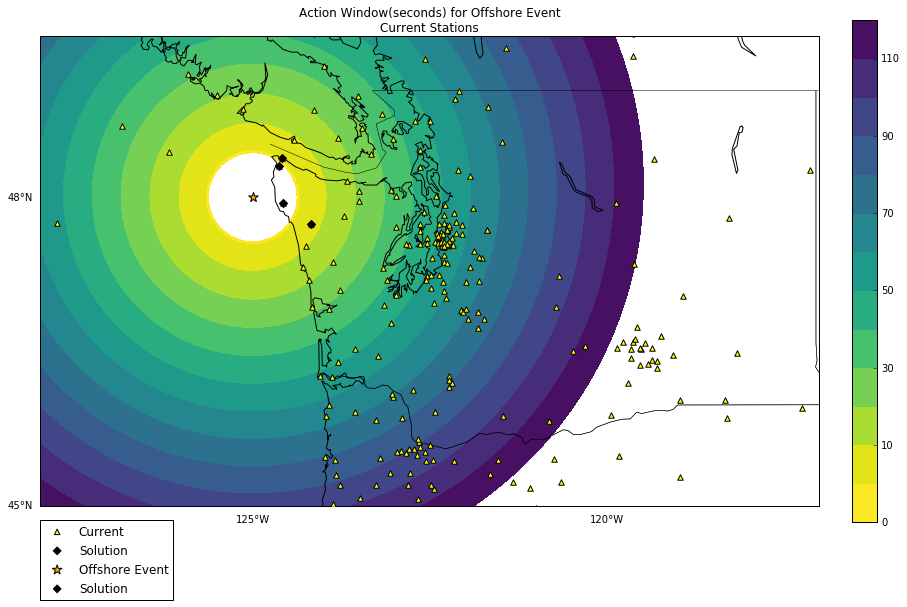

In [56]:
%run -i scripts/plot_heatmap.py \
--path=$grid_offshore_alert_path \
--title1="Action Window(seconds) for Offshore Event" \
--title2="Current Stations" \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,1,10,20,30,40,50,60,70,80,90,100,110,120

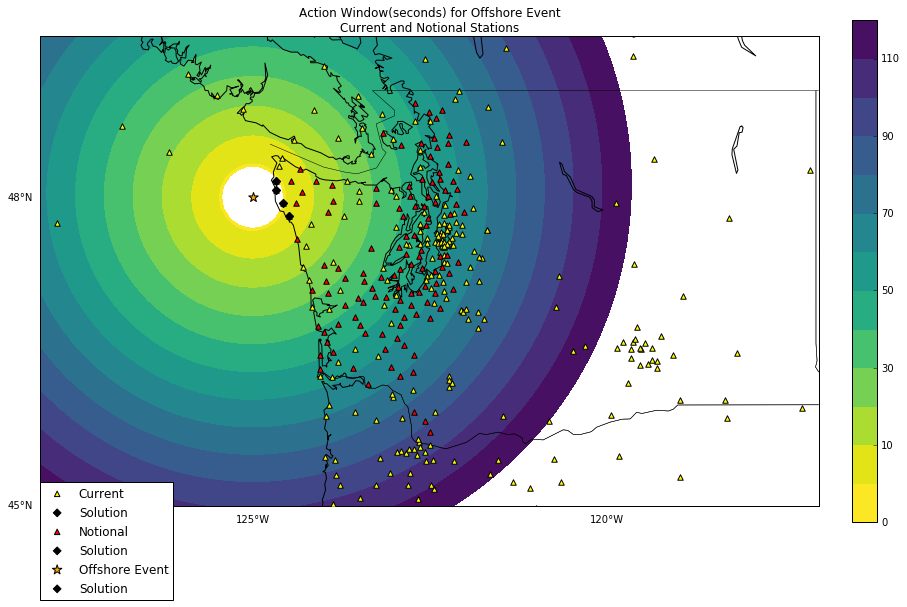

In [57]:
%run -i scripts/plot_heatmap.py \
--path=$grid_offshore_n_alert_path \
--title1="Action Window(seconds) for Offshore Event" \
--title2="Current and Notional Stations" \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,1,10,20,30,40,50,60,70,80,90,100,110,120

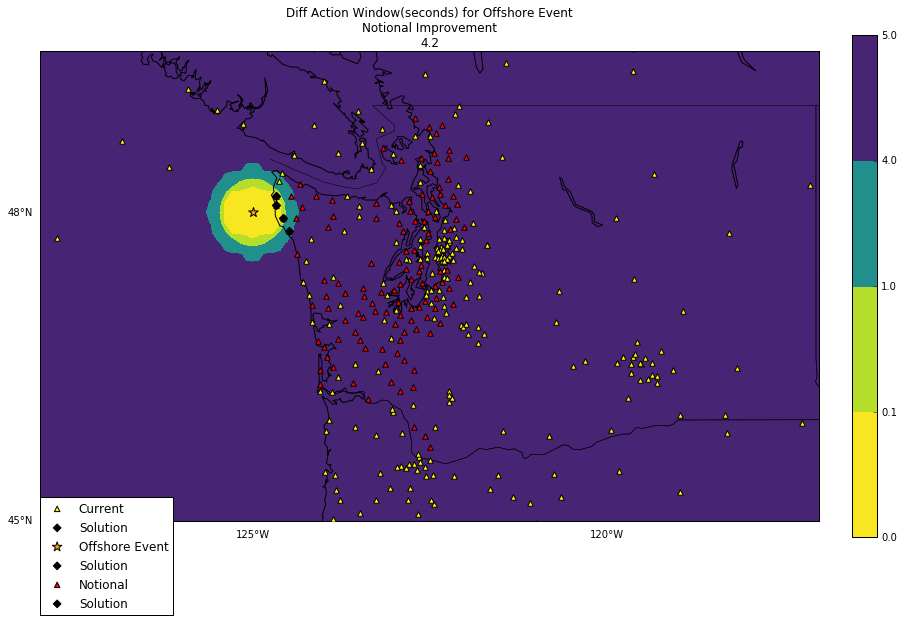

In [58]:
%run -i scripts/plot_heatmap.py \
--path=$grid_diff_offshore_alert_path \
--title1="Diff Action Window(seconds) for Offshore Event" \
--title2="Notional Improvement" \
--title3=$delta_trigger \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,0.1,1,4,5

### Action Window for  Aberdeen event

In [59]:
#name of config file in ./config/{name}.ini
name ="aberdeen"

#contour around event
%run -i scripts/make_grids.py \
--name=$name \
--grid_types=dist_max \
--lat_min=$lat_min \
--lat_max=$lat_max \
--lon_min=$lon_min \
--lon_max=$lon_max \
--resolution=$resolution \
--num_solutions=$num_solutions

#instantiate grid object(s) using _grid_paths dict created by script
#reference with unique key
grid_paths[name] = _grid_paths
grid_aberdeen_event = get_pickle(grid_paths[name]['dist_max'])

Profiling spatially...
Path for dist_max:
  /Users/joncon/Sites/magd_client/scripts/../pickle_jar/aberdeen/dist_max_grid/85x150-res-0.1.pickle


In [60]:
#create a single origin, then find nth closest current station distance
name = "distance_aberdeen_existing"
%run -i scripts/make_grids.py \
--name=washington_current \
--grid_types=dist_max \
--lat_min=$aberdeen_lat \
--lat_max=$aberdeen_lat  \
--lon_min=$aberdeen_lon  \
--lon_max=$aberdeen_lon \
--resolution=$resolution \
--num_solutions=$num_solutions

#instantiate grid object(s) using _grid_paths dict created by script
#reference with unique key
grid_paths[name] = _grid_paths
distance_aberdeen = get_pickle(grid_paths[name]['dist_max'])

Profiling spatially...
Path for dist_max:
  /Users/joncon/Sites/magd_client/scripts/../pickle_jar/washington_current/dist_max_grid/1x1-res-0.1.pickle


In [61]:
#create a single origin, then find nth closest station distance
name = "distance_aberdeen_complete"
%run -i scripts/make_grids.py \
--name=washington_current_and_notional \
--grid_types=dist_max \
--lat_min=$aberdeen_lat \
--lat_max=$aberdeen_lat  \
--lon_min=$aberdeen_lon  \
--lon_max=$aberdeen_lon \
--resolution=$resolution \
--num_solutions=$num_solutions

#instantiate grid object(s) using _grid_paths dict created by script
#reference with unique key
grid_paths[name] = _grid_paths
distance_aberdeen_n = get_pickle(grid_paths[name]['dist_max'])

Profiling spatially...
Path for dist_max:
  /Users/joncon/Sites/magd_client/scripts/../pickle_jar/washington_current_and_notional/dist_max_grid/1x1-res-0.1.pickle


In [86]:
##############################################################
#aberdeen event
###############################################################


print("Distance to 4th station with current stations:")
print(distance_aberdeen.matrix[0][0])

print("Distance to 4th station with current and notional stations:")
print(distance_aberdeen_n.matrix[0][0])

station_markers = distance_aberdeen.markers


#from distance path, find trigger time. Use this time for every point in eq contour map
travel_current=distance_aberdeen.copy("travel_time", "aberdeen20")
travel_current.transform_to_trigger_time(velocity_p, processing_time, aberdeen_depth)
travel_current.save()

#trigger time (seconds)
trigger_time= travel_current.matrix[0][0]
print("aberdeen trigger time")
print(trigger_time)

#subtract contour grid from this value
grid_aberdeen_alert = grid_aberdeen_event.copy("event_warning", "aberdeen20")
grid_aberdeen_alert.markers =  {**station_markers, **grid_aberdeen_alert.markers}
grid_aberdeen_alert.firstn_solutions =distance_aberdeen.firstn_solutions
grid_aberdeen_alert.transform_to_s_travel_time(velocity_s, aberdeen_depth)
grid_aberdeen_alert.matrix =  grid_aberdeen_alert.matrix -trigger_time 
grid_aberdeen_alert.matrix.clip(0)
grid_aberdeen_alert.save()
grid_aberdeen_alert_path = grid_aberdeen_alert.get_path()


#distance from event to 4th current notional station. matrix is 1x1


station_n_markers = distance_aberdeen_n.markers

#from distance path, find trigger time. Use this time for every point in eq contour map
travel_notional=distance_aberdeen_n.copy("travel_time", "aberdeen_n20")
travel_notional.transform_to_trigger_time(velocity_p, processing_time, aberdeen_depth)
travel_notional.save()

#trigger time (seconds)
trigger_time_n = travel_notional.matrix[0][0]
print("aberdeen trigger time")
print(trigger_time_n)
delta_trigger = (trigger_time - trigger_time_n).round(2)
print("delta trigger time:")
print(delta_trigger)
delta_string= "Notional Improvement: {}".format(delta_trigger) 

#subtract contour grid from this value
grid_aberdeen_n_alert = grid_aberdeen_event.copy("event_warning", "aberdeen20_notional")
grid_aberdeen_n_alert.markers =  {**station_n_markers, **grid_aberdeen_n_alert.markers}
grid_aberdeen_n_alert.firstn_solutions = distance_aberdeen_n.firstn_solutions
grid_aberdeen_n_alert.transform_to_s_travel_time(velocity_s, aberdeen_depth)
grid_aberdeen_n_alert.matrix =  grid_aberdeen_n_alert.matrix -trigger_time_n 
grid_aberdeen_n_alert.matrix.clip(0)
grid_aberdeen_n_alert.save()
grid_aberdeen_n_alert_path = grid_aberdeen_n_alert.get_path()

#diff the two
grid_diff_aberdeen_alert = grid_aberdeen_n_alert.copy("event_warning_diff", "diff_aberdeen20")
grid_diff_aberdeen_alert.matrix =  grid_aberdeen_n_alert.matrix.clip(0) - grid_aberdeen_alert.matrix.clip(0)

grid_diff_aberdeen_alert.matrix.clip(0)
grid_diff_aberdeen_alert.save()
grid_diff_aberdeen_alert_path = grid_diff_aberdeen_alert.get_path()

Distance to 4th station with current stations:
27.8279942952
Distance to 4th station with current and notional stations:
17.8555394454
aberdeen trigger time
15.4146761151
aberdeen trigger time
14.7084769072
delta trigger time:
0.71


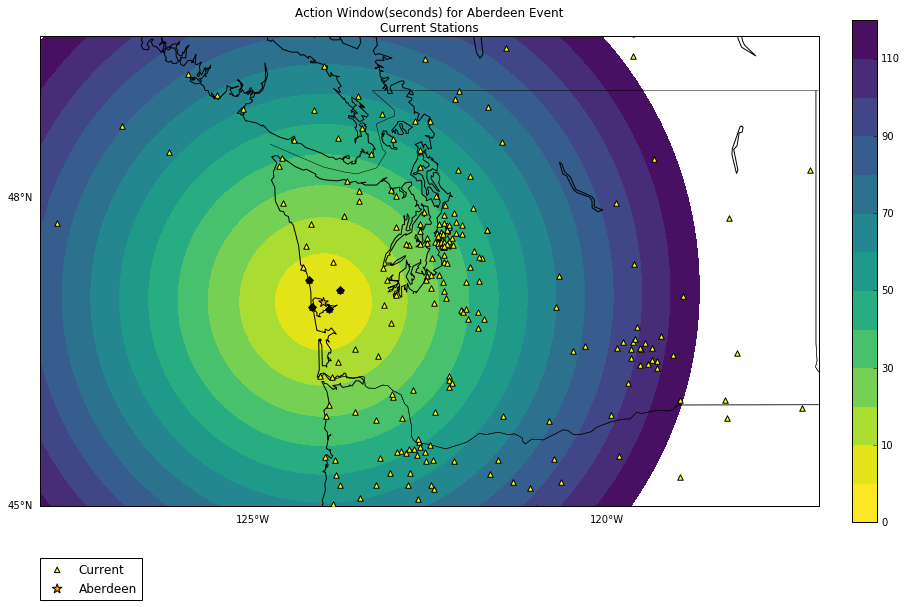

In [88]:
%run -i scripts/plot_heatmap.py \
--path=$grid_aberdeen_alert_path \
--title1="Action Window(seconds) for Aberdeen Event" \
--title2="Current Stations" \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,1,10,20,30,40,50,60,70,80,90,100,110,120

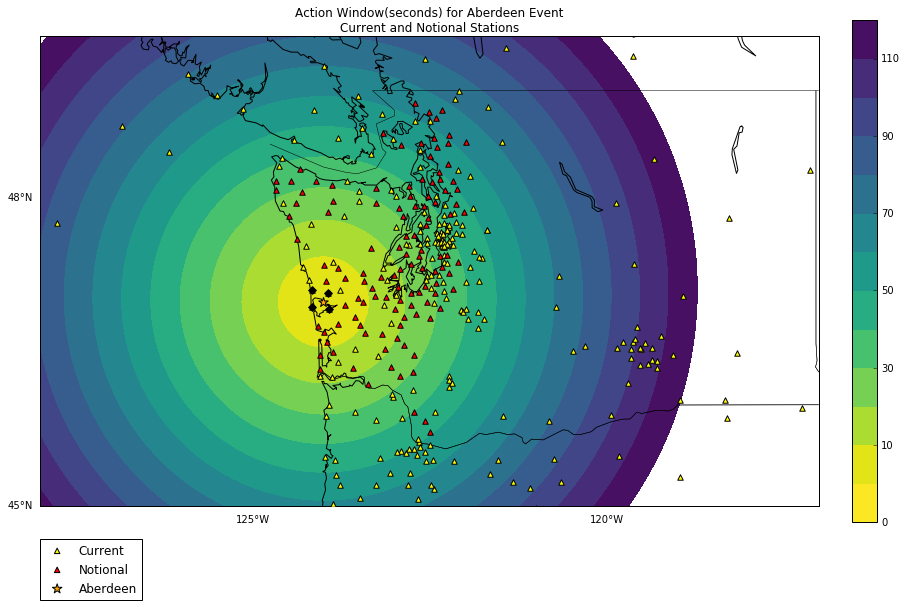

In [89]:
%run -i scripts/plot_heatmap.py \
--path=$grid_aberdeen_n_alert_path \
--title1="Action Window(seconds) for Aberdeen Event" \
--title2="Current and Notional Stations" \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,1,10,20,30,40,50,60,70,80,90,100,110,120

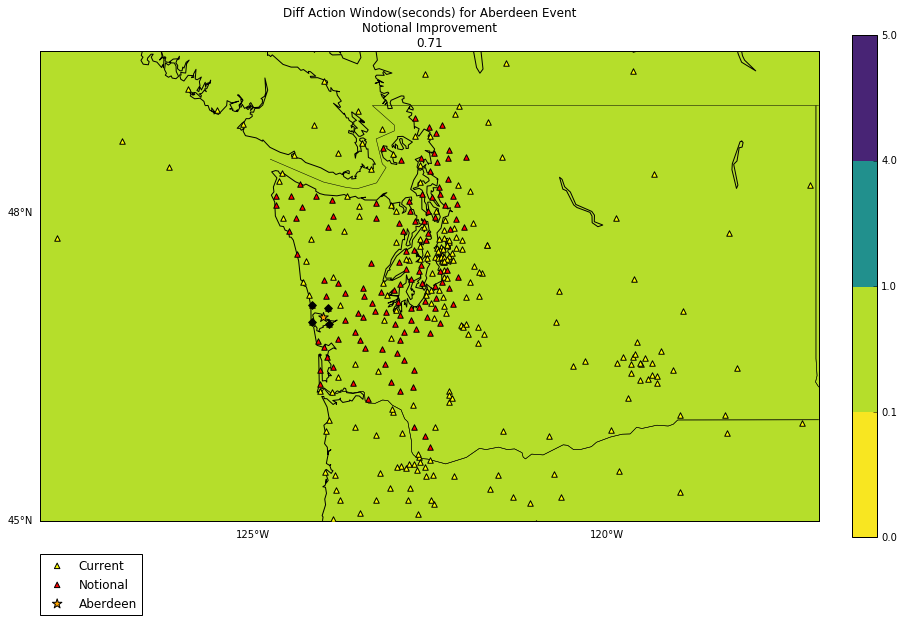

In [67]:
%run -i scripts/plot_heatmap.py \
--path=$grid_diff_aberdeen_alert_path \
--title1="Diff Action Window(seconds) for Aberdeen Event" \
--title2="Notional Improvement" \
--title3=$delta_trigger \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,0.1,1,4,5

### Action Window for  Mt. Buckner event

In [69]:
#name of config file in ./config/{name}.ini
name ="buckner"

#contour around event
%run -i scripts/make_grids.py \
--name=$name \
--grid_types=dist_max \
--lat_min=$lat_min \
--lat_max=$lat_max \
--lon_min=$lon_min \
--lon_max=$lon_max \
--resolution=$resolution \
--num_solutions=$num_solutions

#instantiate grid object(s) using _grid_paths dict created by script
#reference with unique key
grid_paths["grid_buckner_event"] = _grid_paths
grid_buckner_event = get_pickle(grid_paths['grid_buckner_event']['dist_max'])

Profiling spatially...
Path for dist_max:
  /Users/joncon/Sites/magd_client/scripts/../pickle_jar/buckner/dist_max_grid/85x150-res-0.1.pickle


In [70]:
#name of config file in ./config/{name}.ini
name ="washington_current"

#create a single origin, then find nth closest current station distance
%run -i scripts/make_grids.py \
--name=$name \
--grid_types=dist_max \
--lat_min=$buckner_lat \
--lat_max=$buckner_lat  \
--lon_min=$buckner_lon  \
--lon_max=$buckner_lon \
--resolution=$resolution \
--num_solutions=$num_solutions

#instantiate grid object(s) using _grid_paths dict created by script
#reference with unique key
grid_paths["distance_buckner"] = _grid_paths
distance_buckner = get_pickle(grid_paths['distance_buckner']['dist_max'])

Profiling spatially...
Path for dist_max:
  /Users/joncon/Sites/magd_client/scripts/../pickle_jar/washington_current/dist_max_grid/1x1-res-0.1.pickle


In [71]:
#name of config file in ./config/{name}.ini
name ="washington_current_and_notional"

#create a single origin, then find nth closest station distance
%run -i scripts/make_grids.py \
--name=$name \
--grid_types=dist_max \
--lat_min=$buckner_lat \
--lat_max=$buckner_lat  \
--lon_min=$buckner_lon  \
--lon_max=$buckner_lon \
--resolution=$resolution \
--num_solutions=$num_solutions

#instantiate grid object(s) using _grid_paths dict created by script
#reference with unique key
grid_paths["distance_buckner_n"] = _grid_paths
distance_buckner_n = get_pickle(grid_paths['distance_buckner_n']['dist_max'])

Profiling spatially...
Path for dist_max:
  /Users/joncon/Sites/magd_client/scripts/../pickle_jar/washington_current_and_notional/dist_max_grid/1x1-res-0.1.pickle


In [90]:

##############################################################
#buckner event
###############################################################

print("Distance to 4th station with current stations:")
print(distance_buckner.matrix[0][0])

print("Distance to 4th station with current and notional stations:")
print(distance_buckner_n.matrix[0][0])

station_markers = distance_buckner.markers


#from distance path, find trigger time. Use this time for every point in eq contour map
travel_current=distance_buckner.copy("travel_time", "buckner20")
travel_current.transform_to_trigger_time(velocity_p, processing_time, buckner_depth)
travel_current.save()

#trigger time (seconds)
trigger_time= travel_current.matrix[0][0]
print("buckner trigger time")
print(trigger_time)

#subtract contour grid from this value
grid_buckner_alert = grid_buckner_event.copy("event_warning", "buckner20")
grid_buckner_alert.markers =  {**station_markers, **grid_buckner_alert.markers}
grid_buckner_alert.firstn_solutions =distance_buckner.firstn_solutions
grid_buckner_alert.transform_to_s_travel_time(velocity_s, buckner_depth)
grid_buckner_alert.matrix =  grid_buckner_alert.matrix -trigger_time 
grid_buckner_alert.matrix.clip(0)
grid_buckner_alert.save()
grid_buckner_alert_path = grid_buckner_alert.get_path()


#distance from event to 4th current notional station. matrix is 1x1


station_n_markers = distance_buckner_n.markers

#from distance path, find trigger time. Use this time for every point in eq contour map
travel_notional=distance_buckner_n.copy("travel_time", "buckner_n20")
travel_notional.transform_to_trigger_time(velocity_p, processing_time, buckner_depth)
travel_notional.save()

#trigger time (seconds)
trigger_time_n = travel_notional.matrix[0][0]
print("buckner trigger time")
print(trigger_time_n)
delta_trigger = (trigger_time - trigger_time_n).round(2)
print("delta trigger time:")
print(delta_trigger)
delta_string= "Notional Improvement: {}".format(delta_trigger) 

#subtract contour grid from this value
grid_buckner_n_alert = grid_buckner_event.copy("event_warning", "buckner20_notional")
grid_buckner_n_alert.markers =  {**station_n_markers, **grid_buckner_n_alert.markers}
grid_buckner_n_alert.firstn_solutions = distance_buckner_n.firstn_solutions
grid_buckner_n_alert.transform_to_s_travel_time(velocity_s, buckner_depth)
grid_buckner_n_alert.matrix =  grid_buckner_n_alert.matrix -trigger_time_n 
grid_buckner_n_alert.matrix.clip(0)
grid_buckner_n_alert.save()
grid_buckner_n_alert_path = grid_buckner_n_alert.get_path()

#diff the two

grid_diff_buckner_alert = grid_buckner_n_alert.copy("event_warning_diff", "diff_buckner20")
grid_diff_buckner_alert.matrix =  grid_buckner_n_alert.matrix.clip(0) - grid_buckner_alert.matrix.clip(0)


# grid_diff_buckner_alert.matrix.clip(0)
grid_diff_buckner_alert.save()
grid_diff_buckner_alert_path = grid_diff_buckner_alert.get_path()

Distance to 4th station with current stations:
85.5097015054
Distance to 4th station with current and notional stations:
76.3923611418
buckner trigger time
19.9430453332
buckner trigger time
18.2674253202
delta trigger time:
1.68


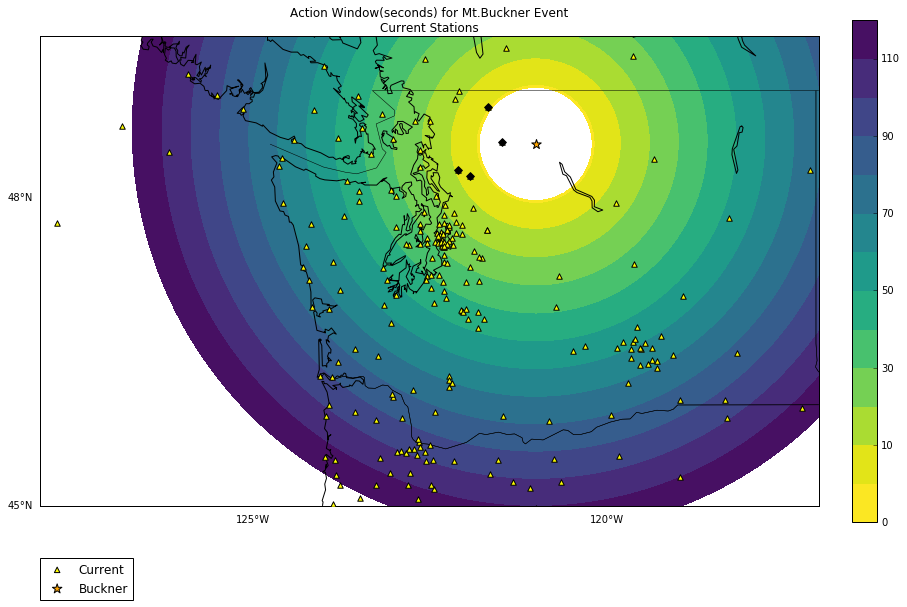

In [91]:
%run -i scripts/plot_heatmap.py \
--path=$grid_buckner_alert_path \
--title1="Action Window(seconds) for Mt.Buckner Event" \
--title2="Current Stations" \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,1,10,20,30,40,50,60,70,80,90,100,110,120

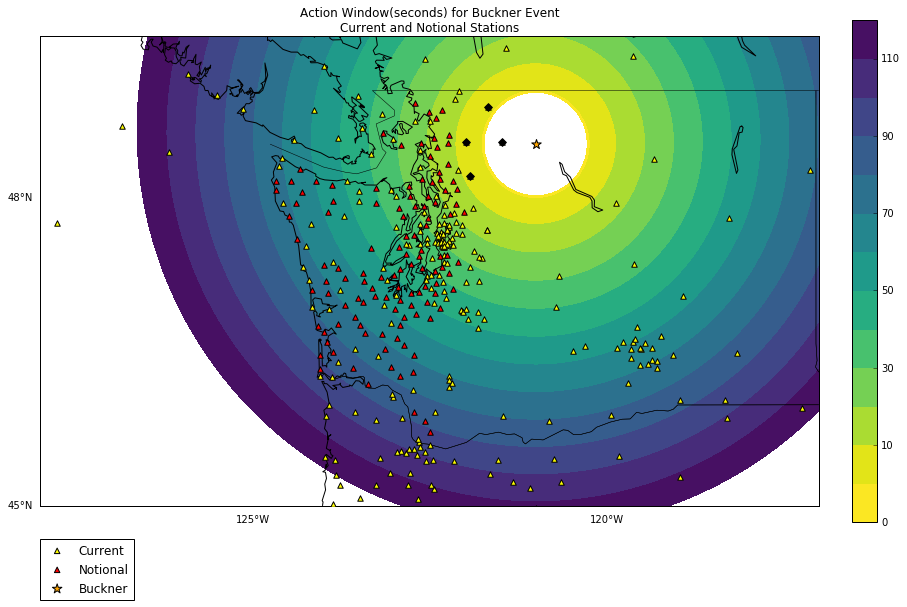

In [92]:
%run -i scripts/plot_heatmap.py \
--path=$grid_buckner_n_alert_path \
--title1="Action Window(seconds) for Buckner Event" \
--title2="Current and Notional Stations" \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,1,10,20,30,40,50,60,70,80,90,100,110,120

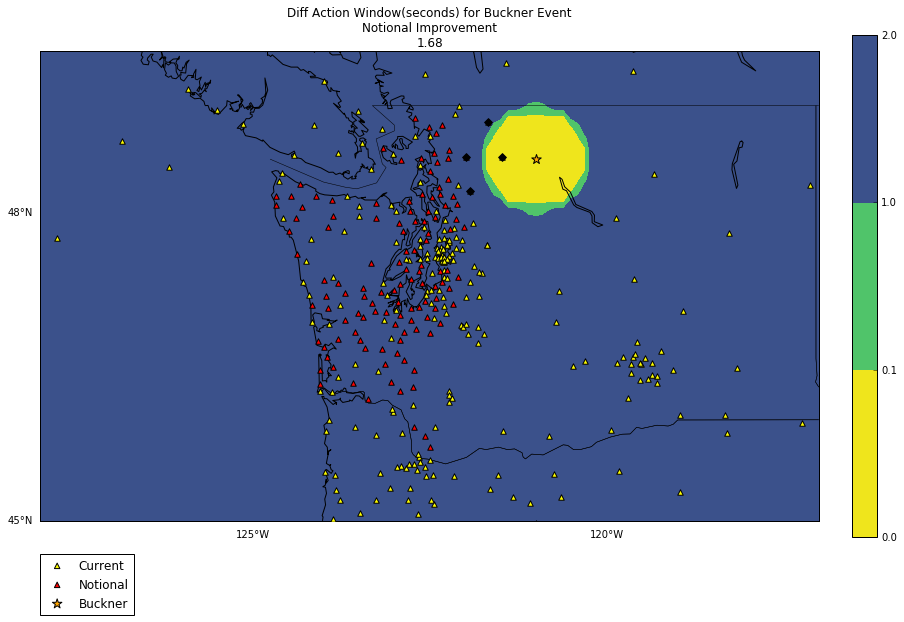

In [93]:
%run -i scripts/plot_heatmap.py \
--path=$grid_diff_buckner_alert_path \
--title1="Diff Action Window(seconds) for Buckner Event" \
--title2="Notional Improvement" \
--title3=$delta_trigger \
--plotstas=True \
--plotwidth=15 \
--color=viridis_r \
--levels=0,0.1,1,2